In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

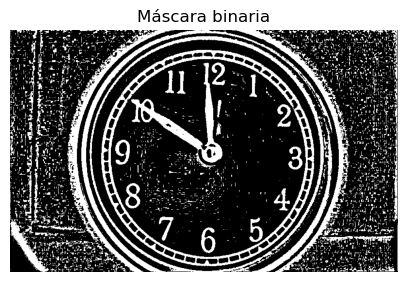

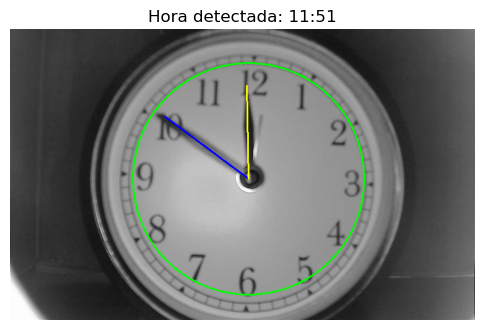

(11.85, 51)

In [5]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

def detectar_hora_radial(imagen_path, mostrar=True, mostrar_mascara=True,
                         delta_grados=3, separacion_max_grados=5):
    img = cv2.imread(imagen_path)
    if img is None:
        raise ValueError("No se pudo leer la imagen")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)

    circles = cv2.HoughCircles(gray_blur, cv2.HOUGH_GRADIENT, dp=1.2,
                           minDist=100, param1=100, param2=30,
                           minRadius=50, maxRadius=200)

    if circles is None:
        raise ValueError("No se detectó un círculo del reloj")

    circles = np.around(circles)  # no usar np.uint16 aquí
    x_center, y_center, r = circles[0][0]

    # desplazar centro manualmente
    offset_x = 4   # píxeles a la derecha
    offset_y = -15  # píxeles arriba
    x_center = int(x_center + offset_x)
    y_center = int(y_center + offset_y)
    r = int(r)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    thresh = cv2.adaptiveThreshold(v, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV,
                                   31, 2)

    if mostrar_mascara:
        plt.figure(figsize=(5,5))
        plt.imshow(thresh, cmap='gray')
        plt.title("Máscara binaria")
        plt.axis('off')
        plt.show()

    angulos = np.linspace(0, 2*np.pi, 360, endpoint=False)
    intensidades = []
    delta = np.deg2rad(delta_grados)

    # Intensidad media en abanico angular
    for ang in angulos:
        angs_sector = np.linspace(ang-delta, ang+delta, 5)
        xs_sector, ys_sector = [], []
        for a in angs_sector:
            xs = x_center + np.cos(a)*np.arange(15, int(r*0.8))
            ys = y_center - np.sin(a)*np.arange(15, int(r*0.8))
            xs_sector.append(xs)
            ys_sector.append(ys)
        xs_sector = np.clip(np.array(xs_sector), 0, thresh.shape[1]-1).astype(int)
        ys_sector = np.clip(np.array(ys_sector), 0, thresh.shape[0]-1).astype(int)
        intensidades.append(np.mean(thresh[ys_sector, xs_sector]))
    intensidades = np.array(intensidades)

    # ángulos ordenados por intensidad descendente
    indices_orden = np.argsort(intensidades)[::-1]
    angulos_orden = angulos[indices_orden]

    # Tomar los dos primeros picos fusionando si están demasiado cerca
    angs_detectados = []
    for ang in angulos_orden:
        if not angs_detectados:
            angs_detectados.append(ang)
        else:
            dif = abs(np.rad2deg((ang - angs_detectados[-1] + np.pi) % (2*np.pi) - np.pi))
            if dif < separacion_max_grados:
                angs_detectados[-1] = (angs_detectados[-1] + ang) / 2.0
            else:
                angs_detectados.append(ang)
        if len(angs_detectados) == 2:
            break

    if len(angs_detectados) < 2:
        raise ValueError("No se detectaron dos agujas claramente")

    angs_rad = np.array(angs_detectados)

    # medir longitud y densidad de blanco de cada aguja
    longitudes = []
    densidades = []
    for ang in angs_rad:
        angs_sector = np.linspace(ang-delta, ang+delta, 5)
        longitudes_sector = []
        densidades_sector = []
        for a in angs_sector:
            xs = x_center + np.cos(a)*np.arange(15, int(r*0.8))
            ys = y_center - np.sin(a)*np.arange(15, int(r*0.8))
            xs = np.clip(xs, 0, thresh.shape[1]-1).astype(int)
            ys = np.clip(ys, 0, thresh.shape[0]-1).astype(int)
            vals = thresh[ys, xs]
            longitud = np.argmax(vals == 0) if np.any(vals==0) else len(vals)
            longitudes_sector.append(longitud)
            densidades_sector.append(np.mean(vals==255))
        longitudes.append(np.mean(longitudes_sector))
        densidades.append(np.mean(densidades_sector))

    long_rel = np.array(longitudes) / float(r)
    densidades = np.array(densidades)

    # asignar minutero/hora según densidad de blanco (o mezcla densidad+longitud)
    # aquí usamos solo densidad: la aguja con mayor densidad de blanco alrededor es minutero
    idx_min = np.argmax(densidades)
    idx_hor = 1 - idx_min

    ang_minuto_rad = angs_rad[idx_min]
    ang_hora_rad = angs_rad[idx_hor]

    ang_minuto = math.degrees(ang_minuto_rad)
    ang_hora = math.degrees(ang_hora_rad)

    minuto = int(((90 - ang_minuto) % 360) / 6)
    hora = int(((90 - ang_hora) % 360) / 30)
    hora = (hora + (minuto/60)) % 12

    if mostrar:
        img_draw = img.copy()
        cv2.circle(img_draw, (x_center, y_center), int(r), (0,255,0), 2)
        # minutero en azul
        x_end_m = int(x_center + r*0.9*np.cos(ang_minuto_rad))
        y_end_m = int(y_center - r*0.9*np.sin(ang_minuto_rad))
        cv2.line(img_draw, (x_center, y_center), (x_end_m, y_end_m), (255,0,0), 2)
        # horario en amarillo
        x_end_h = int(x_center + r*0.8*np.cos(ang_hora_rad))
        y_end_h = int(y_center - r*0.8*np.sin(ang_hora_rad))
        cv2.line(img_draw, (x_center, y_center), (x_end_h, y_end_h), (0,255,255), 2)
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
        plt.title(f"Hora detectada: {int(hora):02d}:{int(minuto):02d}")
        plt.axis('off')
        plt.show()

    return hora, minuto

# Uso:
detectar_hora_radial("data-resampled/clock_1150.png")


In [8]:
from glob import glob


imagenes = glob("data-resampled/*.png")
for img_path in imagenes:
    try:
        h, m = detectar_hora_radial(img_path)
        print(f"{img_path}: {h:02d}:{m:02d}")
    except Exception as e:
        print(f"{img_path}: error -> {e}")


data-resampled/clock_1047.png: 10:47
data-resampled/clock_0713.png: 07:13
data-resampled/clock_0625.png: 06:24
data-resampled/clock_0226.png: 02:25
data-resampled/clock_0222.png: 02:22
data-resampled/clock_1331.png: 01:30
data-resampled/clock_0513.png: 05:13
data-resampled/clock_0813.png: 08:13
data-resampled/clock_1011.png: 10:11
data-resampled/clock_0715.png: 09:15
data-resampled/clock_0812.png: 08:12
data-resampled/clock_0716.png: 07:16
data-resampled/clock_1332.png: 01:31
data-resampled/clock_0250.png: 02:50
data-resampled/clock_0200.png: 02:01
data-resampled/clock_0407.png: 04:07
data-resampled/clock_0219.png: 02:19
data-resampled/clock_0302.png: 00:15
data-resampled/clock_0852.png: 08:52
data-resampled/clock_0606.png: 06:06
data-resampled/clock_1212.png: 00:12
data-resampled/clock_1027.png: 10:27
data-resampled/clock_0253.png: 02:54
data-resampled/clock_0953.png: 10:50
data-resampled/clock_0728.png: 07:27
data-resampled/clock_0804.png: 08:04
data-resampled/clock_1132.png: 11:31
d